In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

load data
align fingerprints


In [2]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

# create docking oracle
config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path=f'../../dgym-data/Mpro_prepped.pdbqt',
    config=config
)

In [3]:
generator = library_designer.generate_analogs(deck[0])

# library_designer.enumerate_products(generator, 10)[0]

CPU times: user 799 ms, sys: 36.7 ms, total: 836 ms
Wall time: 92.1 ms


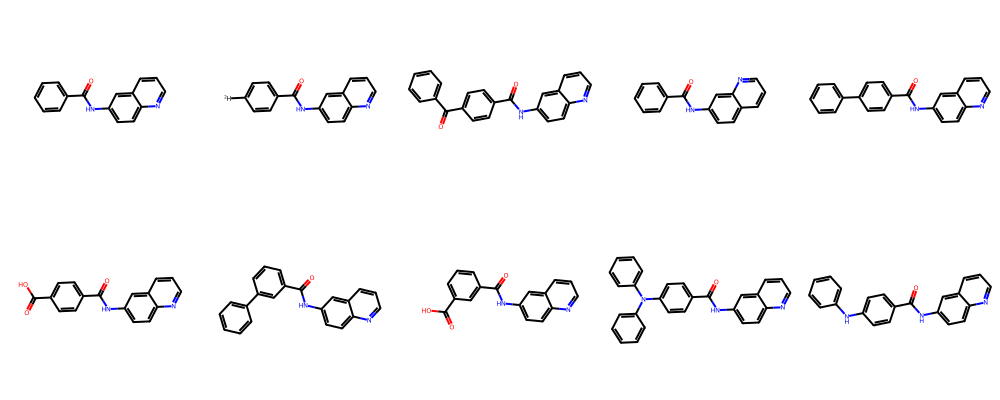

In [1535]:
%%time
# molecule = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1nnc2ccccc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]nnc2ccccc12']
# )

library_designer.reset_cache()
molecules = library_designer.design(
    deck[31],
    size=10,
    mode='analog',
    temperature=0.0
)
MolsToGridImage([m.mol for m in molecules], molsPerRow=5)

In [391]:
%%time
import itertools

reactions = []
for idx, reaction in enumerate(library_designer.reactions):
    for reactant_order in itertools.permutations(deck[31].reactants):
        try:
            if products := reaction.run([m.mol for m in reactant_order]):
                print(idx, reaction.id)
        except:
            pass

12 13_Carboxylate_and_Amine
82 83_Schotten_Baumann_amide
CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 2.24 ms


Brute-force search for comparison.

In [1536]:
probabilities = library_designer.boltzmann(torch.tensor(new_score), temperature=0.0)

In [1555]:
%%time
mol = building_blocks[0]

CPU times: user 225 µs, sys: 6 µs, total: 231 µs
Wall time: 255 µs


In [1878]:
%%time

# get scores
mol = deck[31].reactants[1]
analogs = library_designer.get_analogs([mol])
indices = list(analogs.iter_indices())
scores = list(analogs.iter_scores())

# get analogs
analogs = [building_blocks[i] for i in indices[0][:150]]

# compute size ranks
size = mol.mol.GetNumAtoms()
size_distance = [abs(a.GetNumAtoms() - size) for a in analogs]
size_similarity = 1 / (1 + np.array(size_distance))

new_score = (size_similarity * 1.0) + scores[0][:150]
# analogs = [analogs[i] for i in np.argsort(new_score)[::-1]]

# MolsToGridImage([mol.mol, *analogs[:50]], molsPerRow=5)

CPU times: user 14.7 ms, sys: 0 ns, total: 14.7 ms
Wall time: 15.4 ms


In [2344]:
%%time
_ = [library_designer.building_blocks[i] for i in range(500)]

CPU times: user 53.1 ms, sys: 158 µs, total: 53.2 ms
Wall time: 57.6 ms


In [2403]:
torch.empty(len(analogs))

torch.Size([150])

In [2466]:
%%time
self = library_designer

molecule = deck[31]
original_molecules = molecule.reactants

# Identify analogs of each original reactant
indices, scores = self.get_analog_indices_and_scores(original_molecules)
analogs = []
for indices_ in indices:
    analogs.append([self.building_blocks[i] for i in indices_.tolist()])

CPU times: user 1.43 s, sys: 46.2 ms, total: 1.48 s
Wall time: 162 ms


In [2531]:
%%time
next(library_designer.generate_analogs(deck[31]))

CPU times: user 366 ms, sys: 18.6 ms, total: 385 ms
Wall time: 43 ms


In [2566]:
self.fingerprints[0]

('EN300-07843',
 b'\x00\x01\x04!\x00\x00\x00\x00\x00\x01\x10\x00\x00\x00\x10\x00\x00\x08 \x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x04\x00\x80\x10D\x00\x0c\x00\x00\x00\x00\x04\x00\x00\x02\x00\x00\x00\x00\x00@\x80\x00\x00\x00\x00\x00\x02\x01@\x00\x04\x08\x00\x00\x00\x00\x00\x00\x00\x80\x08\x00\x00\x00\x00\x00\x08\x00@\x00\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x00\x10\x00B\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x01\x00\x00 \x01\x08\x82\x00\x00@\x00')

CPU times: user 1.83 s, sys: 37.2 ms, total: 1.87 s
Wall time: 302 ms


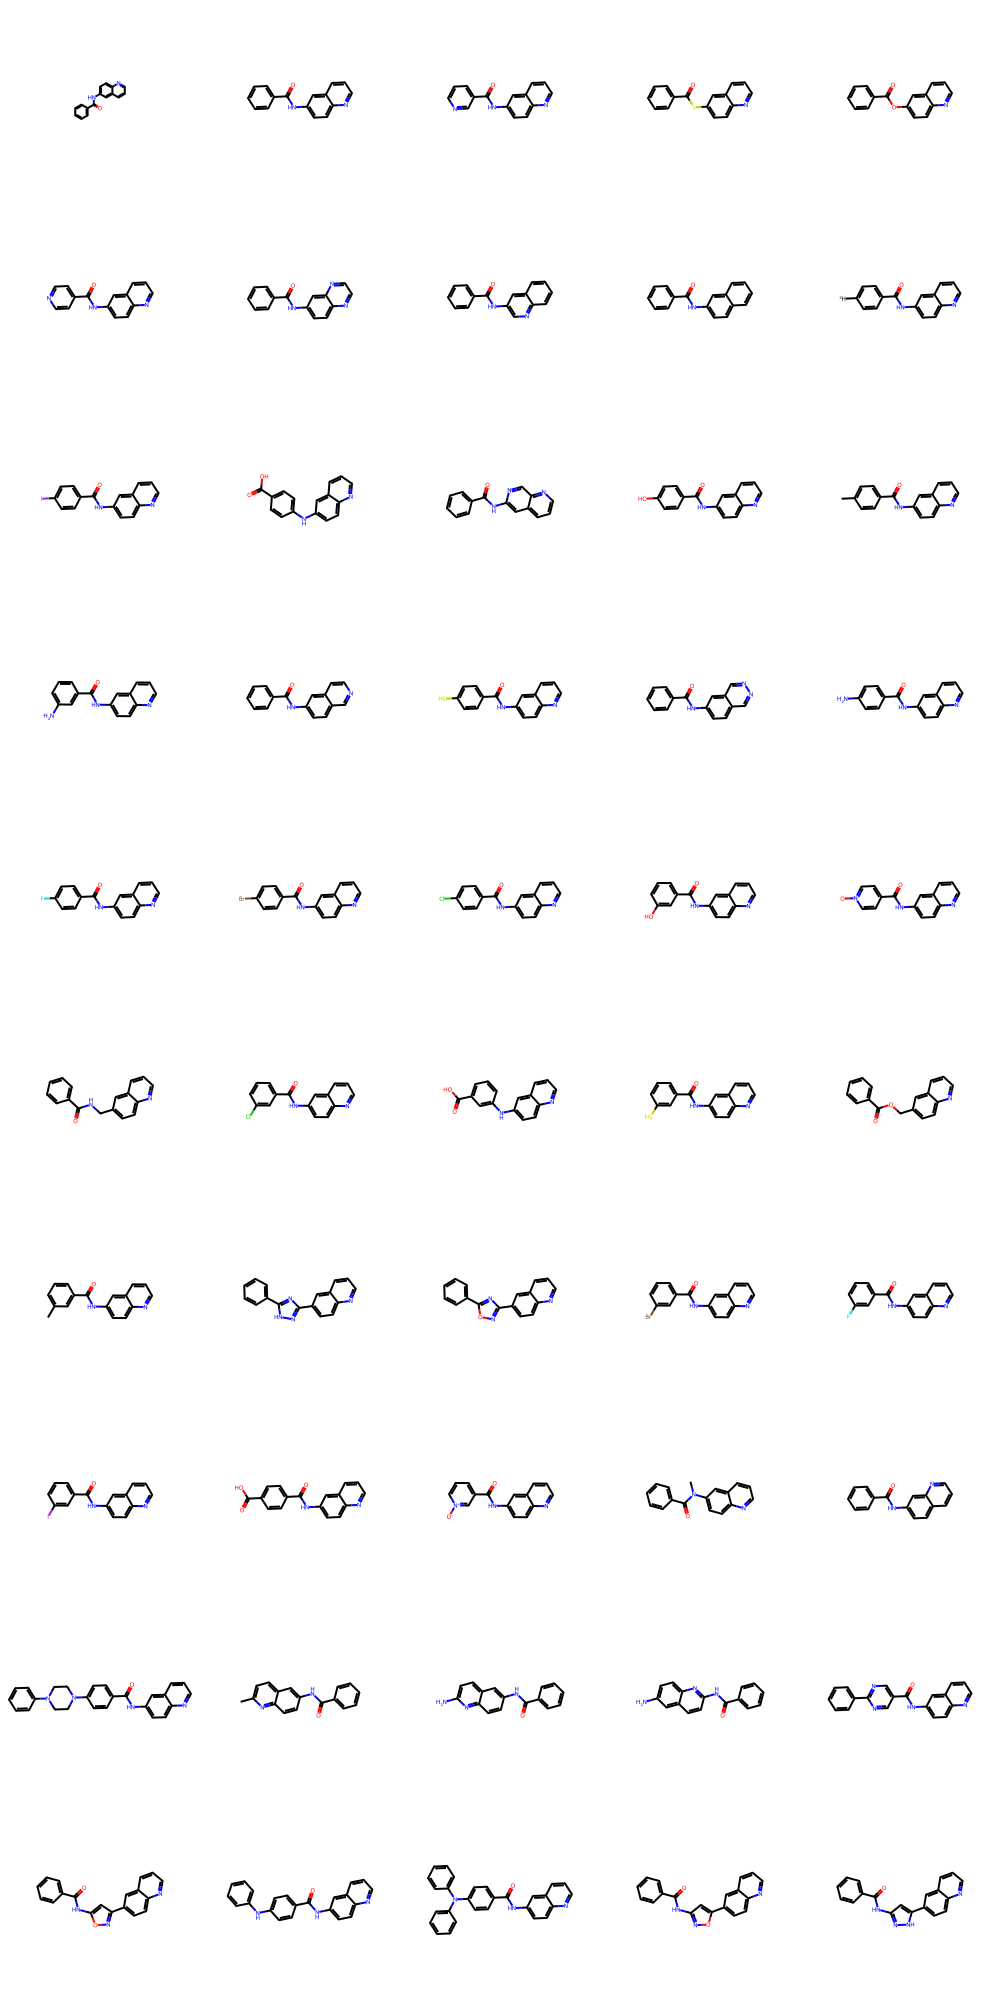

In [2564]:
%%time
library_designer.reset_cache()
products = library_designer.design(deck[31], size=50, temperature=0.0)
MolsToGridImage([deck[31].mol, *[a.mol for a in products]], molsPerRow=5)

  0%|          | 0/5 [00:00<?, ?it/s]

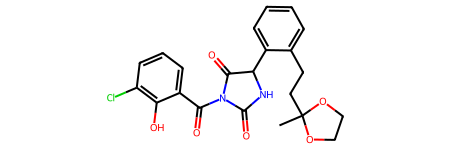

4.187648811909822


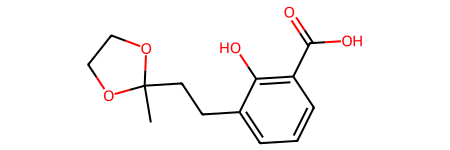

4.47425223998464


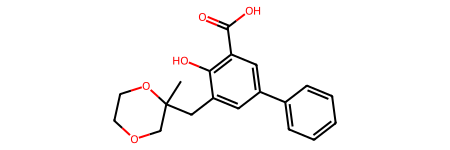

4.603938777273891


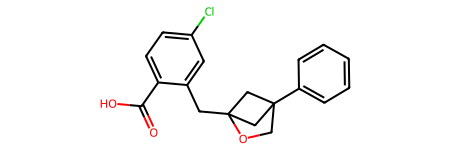

5.036640125791382


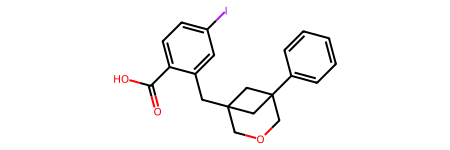

4.9253029732232605


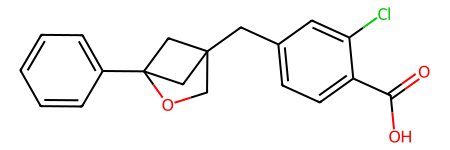

5.2659620819030675


In [546]:
import numpy as np
from tqdm.notebook import tqdm

# best_mol = dg.molecule.Molecule(
#     'O=C(c1ccc2c(=O)[nH][nH]c(=O)c2c1)n1cnc2ccc(F)cc2c1=O',
#     reactants=['O=C(O)c1ccc2c(=O)[nH][nH]c(=O)c2c1',
#                'O=c1[nH]cnc2ccc(F)cc12']
# )
# best_mol = deck[414]
# best_score = docking_oracle([best_mol])

# mols = dg.collection.MoleculeCollection([best_mol])
# all_scores = [best_score]

for _ in tqdm(range(5)):
    
    display(best_mol)
    print(best_score)
    
    analogs = library_designer.design(
        best_mol,
        mode='retrosynthesize',
        temperature=0.3,
        size=10
    )
    mols += analogs

    scores = docking_oracle(analogs)
    all_scores.extend(scores)
    
    best = np.nanargmax(scores).item()
    best_score = scores[best]
    best_mol = analogs[best]
    
display(best_mol)
print(best_score)

In [544]:
analogs

MoleculeCollection with 51 Molecules

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


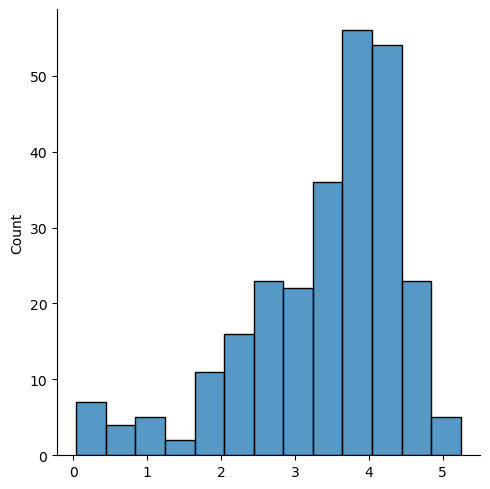

In [545]:
import seaborn as sns
pIC50s = np.array(docking_oracle(mols))
sns.displot(pIC50s[pIC50s > 0.0])